From https://wxradarexplore.com/2020/06/21/ekstrak-data-radar-gematronik-single-pol/

In [1]:
# Make sure the environment is good
import numpy as np
import wradlib as wrl
from datetime import datetime, timedelta
import os, gc, warnings

import matplotlib.pyplot as plt

from matplotlib.colors import from_levels_and_colors

import cartopy.crs as ccrs

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Locating the wradlib path
os.environ["WRADLIB_DATA"] = "D:/wradlib-data-main/"

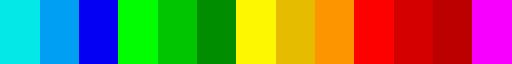

In [3]:
dbz_levels = np.arange(5., 75., 5.)

# Create the color table found on NWS pages.
#[4,233,231], [1,159,244], [3,0,244], [2,253,2], 
dbz_rgb = np.array([[4,233,231], [1,159,244], 
                    [3,0,244], [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198]], np.float32) / 255.0

dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb,
                                           extend="max")
dbz_map

In [4]:
# Open mvol radar
jam = '0900'
f = wrl.util.get_wradlib_data_file('RadarMobileKertajati/20240221'+str(jam)+'0000dBZ.vol')
rbdict = wrl.io.read_rainbow(f)

# Total elevation
nElevation = len(rbdict['volume']['scan']['slice'])

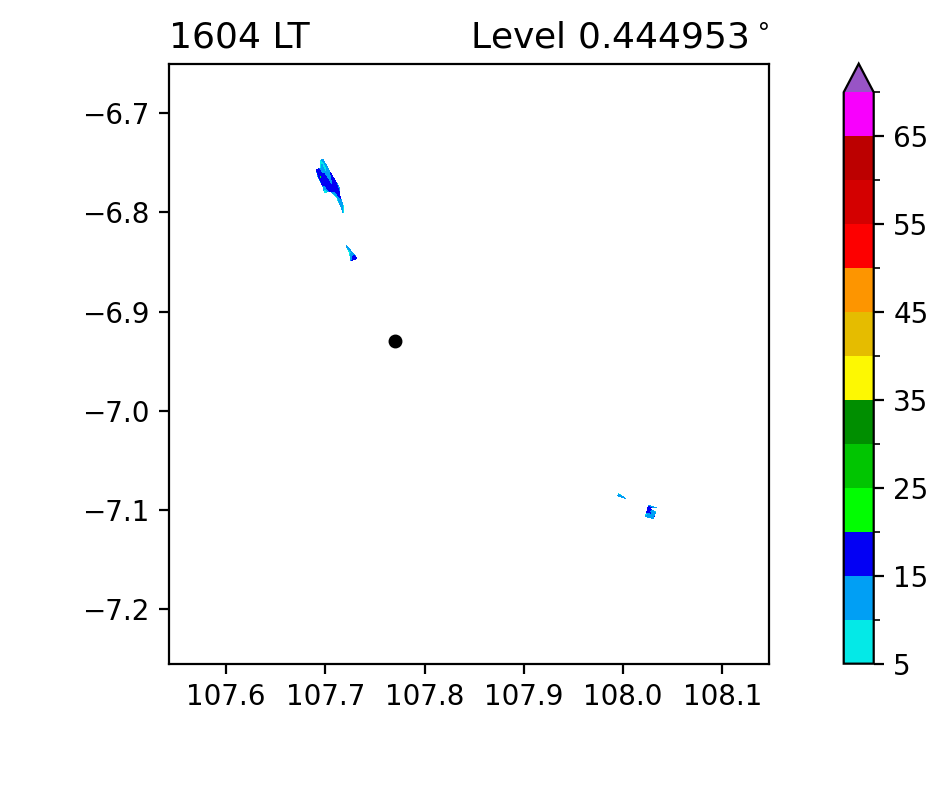

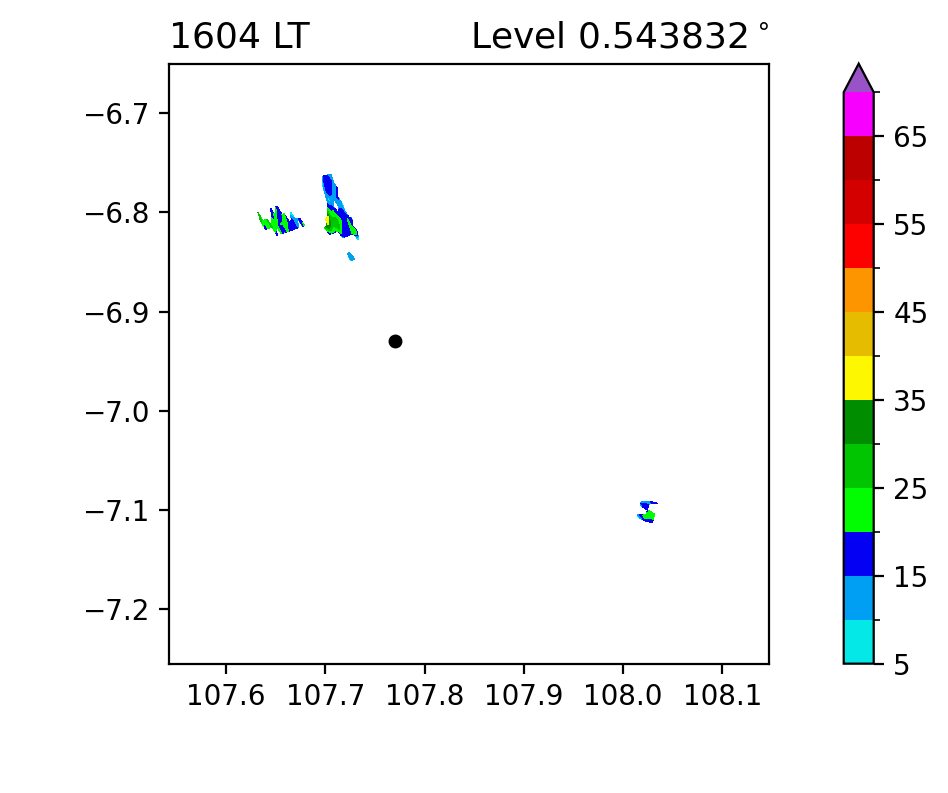

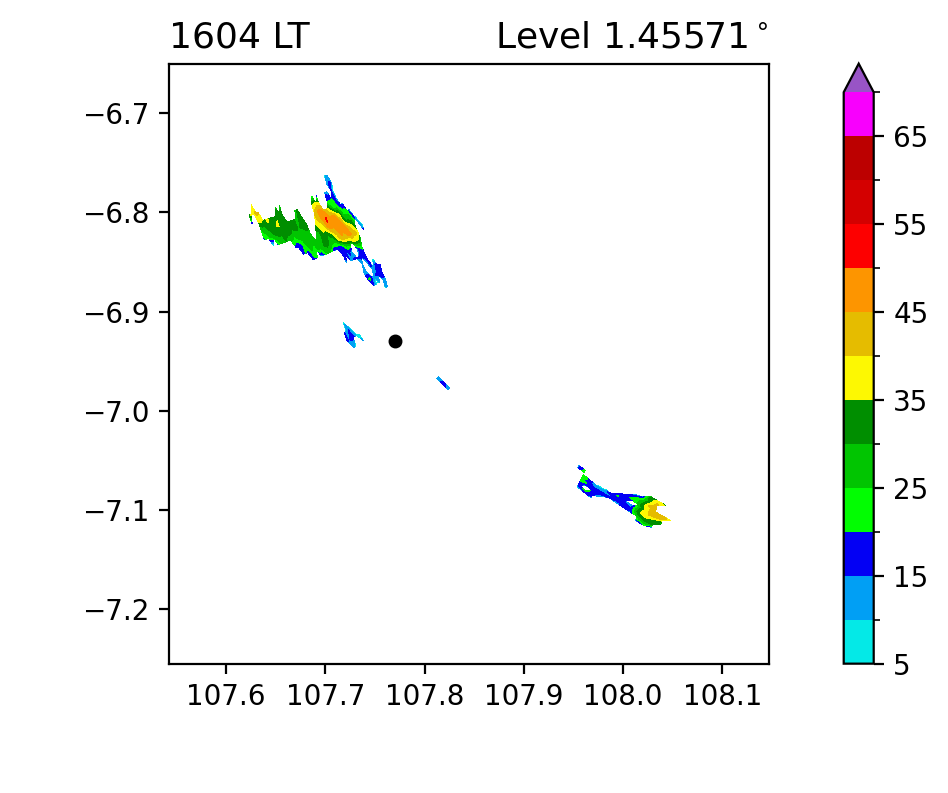

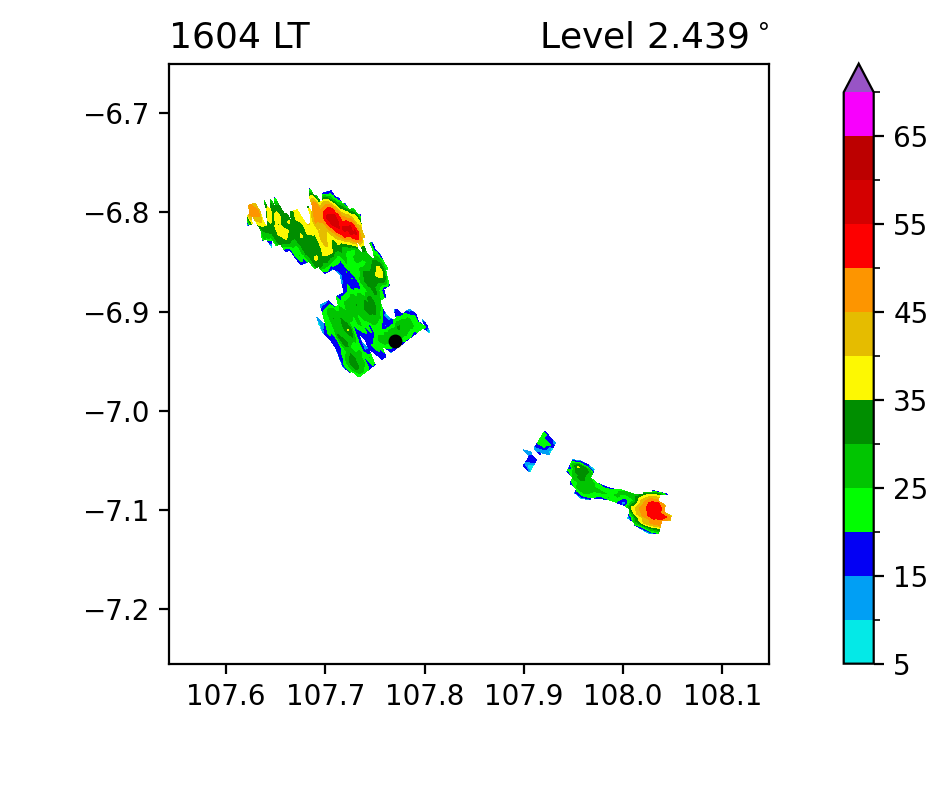

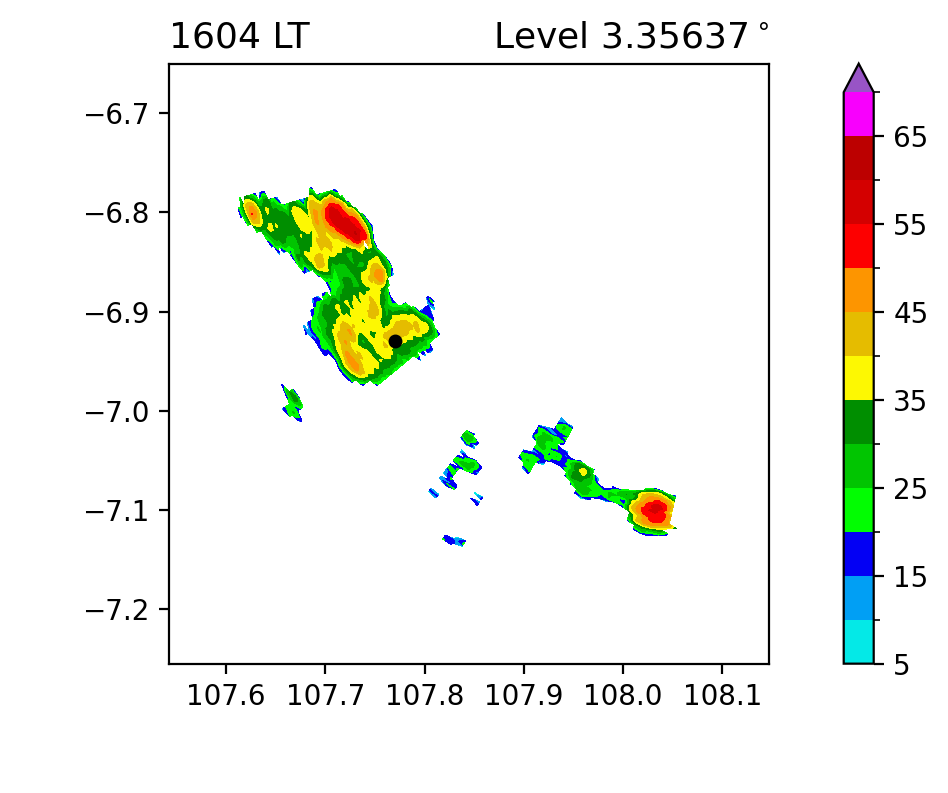

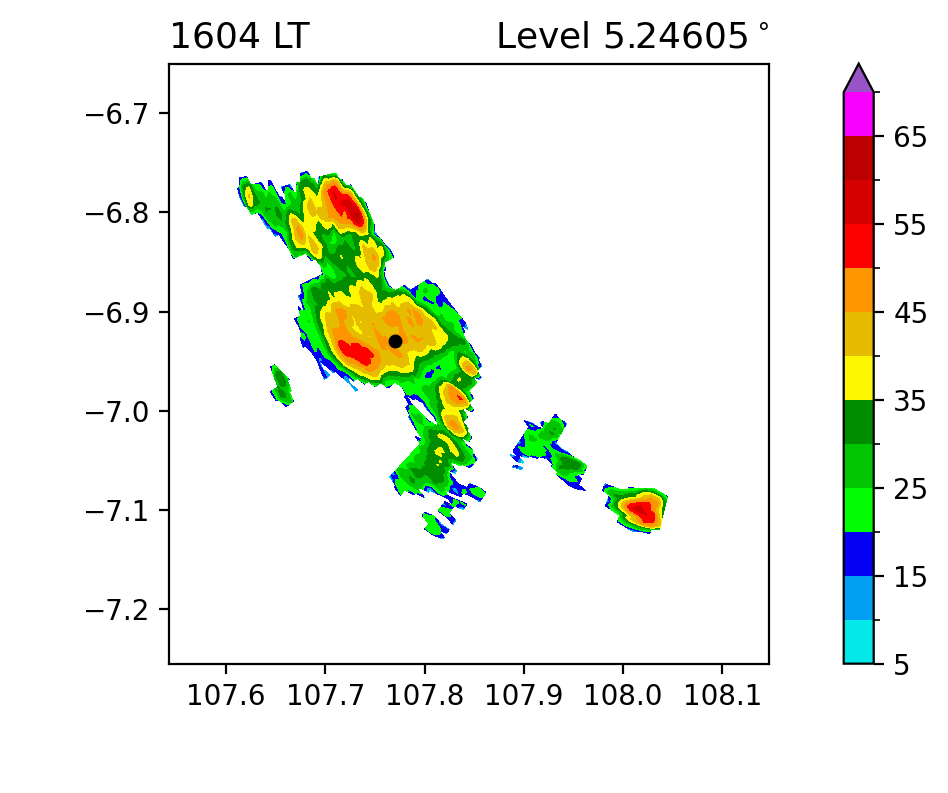

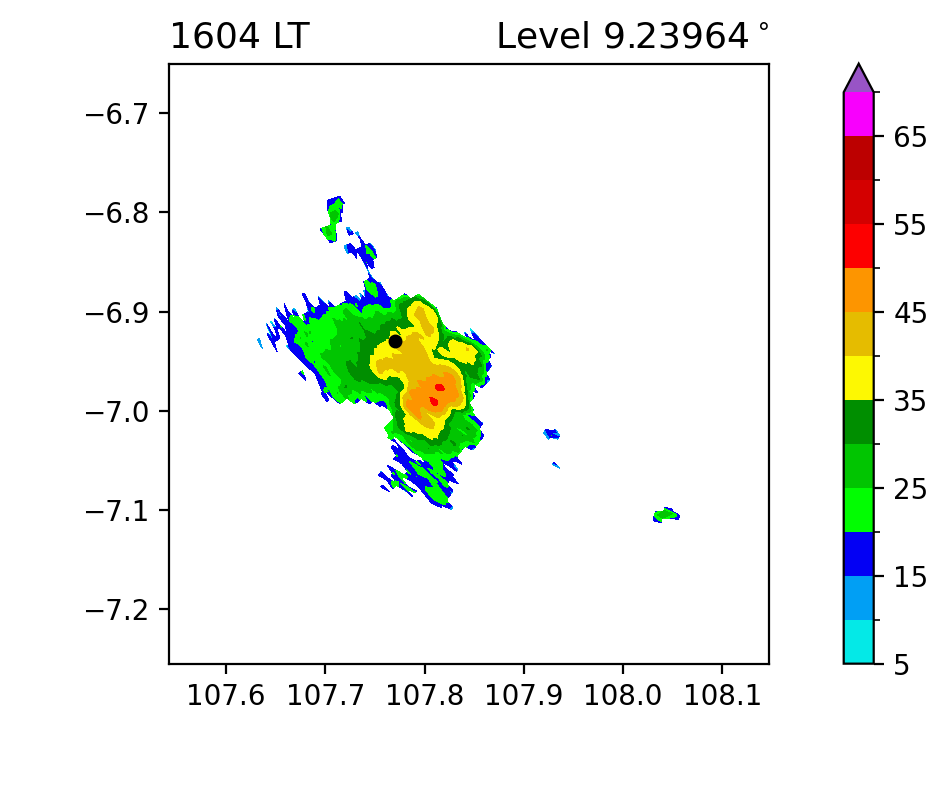

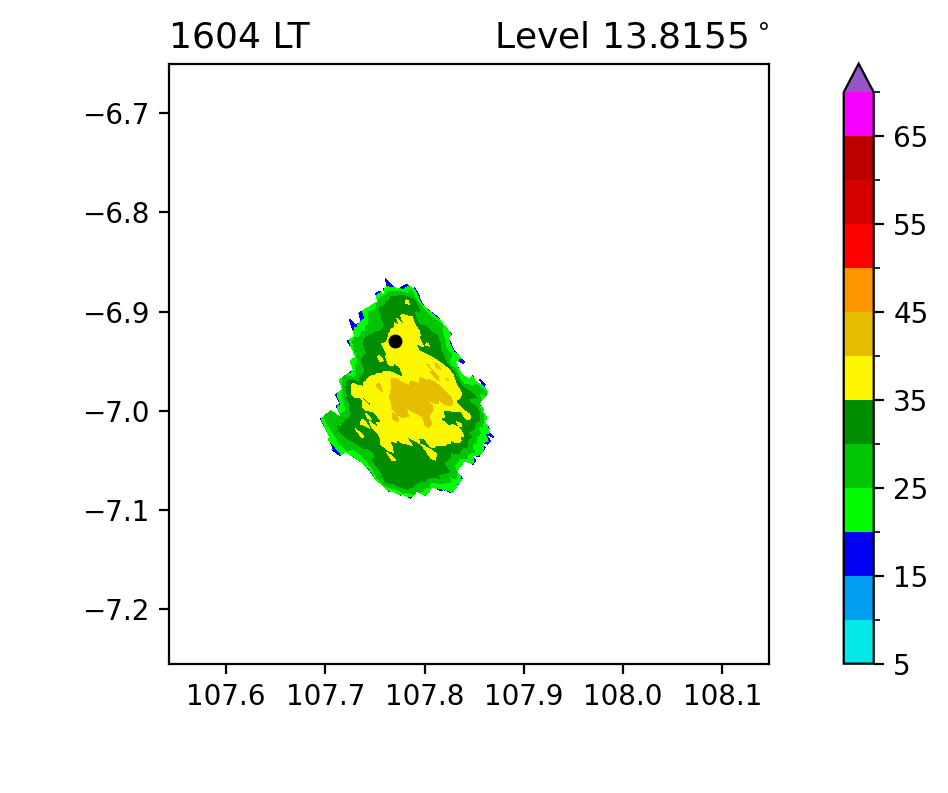

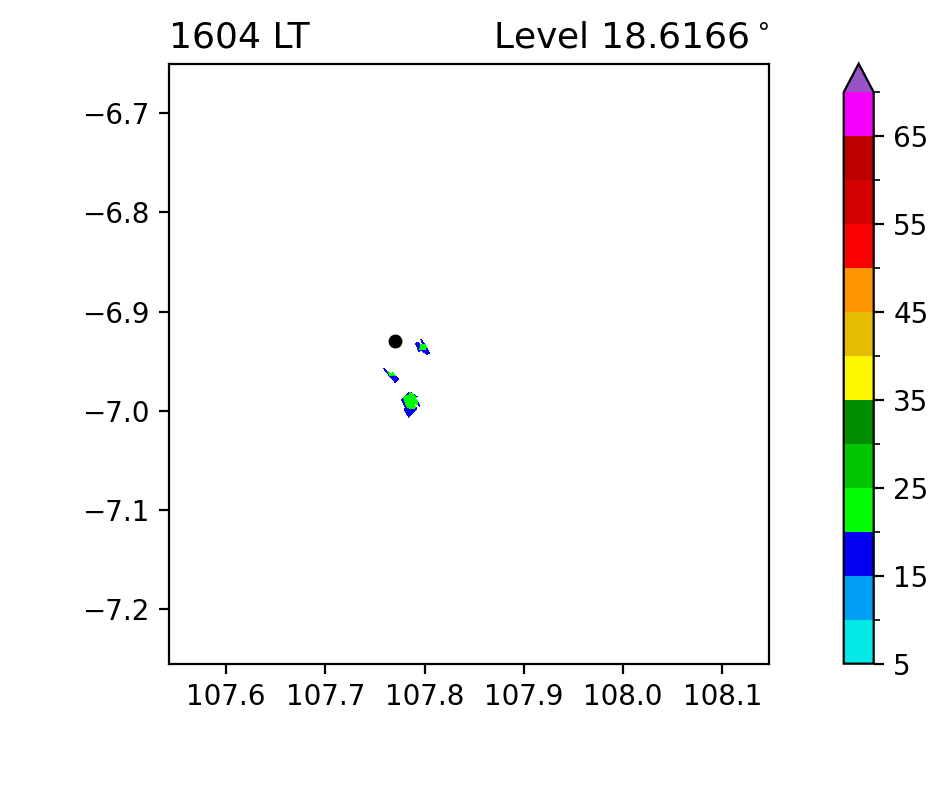

In [5]:
for n in range (0,nElevation,1):
    elevation = float(rbdict['volume']['scan']['slice'][n]['posangle'])

    # Getting azimuth
    azi = rbdict["volume"]["scan"]["slice"][n]["slicedata"]["rayinfo"]["data"]
    azidepth = float(rbdict["volume"]["scan"]["slice"][n]["slicedata"]["rayinfo"]["@depth"])
    azirange = float(rbdict["volume"]["scan"]["slice"][n]["slicedata"]["rayinfo"]["@rays"])
    azires = float(rbdict["volume"]["scan"]["slice"][n]["posangle"])
    azi = (azi * azirange / 2**azidepth) * azires

    # Getting range
    stoprange = float(rbdict["volume"]["scan"]["slice"][n]["stoprange"])
    rangestep = float(rbdict["volume"]["scan"]["slice"][n]["rangestep"])
    r = np.arange(0, stoprange, rangestep)*1000

    # Getting data
    data = rbdict["volume"]["scan"]["slice"][n]["slicedata"]["rawdata"]["data"]
    datadepth = float(rbdict["volume"]["scan"]["slice"][n]["slicedata"]["rawdata"]["@depth"])
    datamin = float(rbdict["volume"]["scan"]["slice"][n]["slicedata"]["rawdata"]["@min"])
    datamax = float(rbdict["volume"]["scan"]["slice"][n]["slicedata"]["rawdata"]["@max"])
    data = datamin + data * (datamax - datamin) / 2**datadepth

    # Get radar information
    unit = rbdict["volume"]["scan"]["slice"][n]["slicedata"]["rawdata"]["@type"]
    time = rbdict["volume"]["scan"]["slice"][n]["slicedata"]["@time"]
    date = rbdict["volume"]["scan"]["slice"][n]["slicedata"]["@date"]
    lon = rbdict["volume"]["sensorinfo"]["lon"]
    lat = rbdict["volume"]["sensorinfo"]["lat"]
    sensortype = rbdict["volume"]["sensorinfo"]["@type"]
    sensorname = rbdict["volume"]["sensorinfo"]["@name"]

    # Converting to xarray data and do georeference
    da = wrl.georef.create_xarray_dataarray(data, r=r, az=azi)
    da['longitude'].values, da['latitude'].values = (108.150398, -6.646800)
    da = da.wrl.georef.georeference()

    # Making NaN data
    da = da.where(da !=-31.5, np.nan)  #-31.89 for V, -31.5 for dbZ

    # Getting time
    date=(rbdict['volume']['scan']['slice'][8]['slicedata']['@date'])
    time=(rbdict['volume']['scan']['slice'][8]['slicedata']['@time'])
    timeEnd=datetime.strptime('{}{}'.format(date,time),"%Y-%m-%d%H:%M:%S")
    waktu = (timeEnd + timedelta(hours=7)).strftime("%H%M")

    # Projecting data
    proj = wrl.georef.get_default_projection()
    da = da.wrl.georef.georeference(crs=proj)

    # Plotting
    fig = plt.figure(figsize=(5, 10), dpi=200)
    ax = fig.add_axes([0, 0, 1.5, 0.3])  #plt.gca()
    pm = da[180:270,180:270].wrl.vis.plot(fig=fig, levels=dbz_levels, cmap=dbz_map, ax=ax, extend='max', func='contourf')
    #contourf = fig.colorbar(pm, location='right', extend='max', shrink=1., pad=.025, ticks=[5,15,25,35,45,55,65])
    #contourf.set_label('Reflectivity [dBZ]',fontsize=13)
    #contourf.ax.tick_params(labelsize=13)
    #contourf.ax.set_yticklabels(['5','15','25','35','45','55','65'])
    
    #ax.plot(107.77160893826122, -6.947805900190807, "kx", markersize=7) # 1534 - Brimob
    #ax.plot(107.78150444029477, -6.951922099277064, "kx", markersize=7) # 1544 - Cinta Mulya
    #ax.plot(107.80308356236954, -6.962952113285317, "kx", markersize=7) # 1554 - Deket Borma
    
    ax.plot(107.76995, -6.92924, "ko", markersize=4) # AWS
    
    ax.set_xlabel(' ',fontsize=18, labelpad=5)
    ax.set_ylabel(' ',fontsize=18, labelpad=5)
    txt = plt.title("   ")
    txt = plt.title("Level "+str(elevation)+"$^\circ$", loc='right', fontsize=13)
    txt = plt.title(str(waktu)+" LT", loc='left', fontsize=13)
    
    #fig.savefig('contourf_'+str(waktu)+'_Lev_'+str(n)+'.png',dpi=300, orientation='landscape', bbox_inches='tight')